In [20]:
import ccModules2 as cc2
import matplotlib.pyplot as plt
%matplotlib inline
import tables
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd

In [18]:
image_file = '/data/JData/A/A57_GtACR_Mi1/A57_Data/20180601_A57/20180601-62-3-flyh-002/20180601-62-3-flyh-002ImageFile.hdf5'
intensity_data = '/data/JData/A/A57_GtACR_Mi1/A57_Data/20180601_A57/20180601-62-3-flyh-002/20180601-62-3-flyh-002_IntensityData.hdf5'

In [3]:
#get image intensity data
timeseries = cc2.read_TimeSeries_HDF5(image_file).getIntensityData()

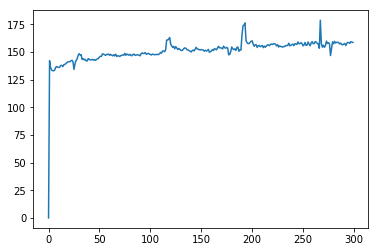

In [4]:
#see stimulation in timeseries
data = timeseries[:, :, :, :, 0]
data = data.squeeze()
data = data.reshape([data.shape[0], data.shape[1] * data.shape[2]])
plt.plot(data.mean(axis=1))

In [5]:
class readIntensityData(object):
    def __init__(self, hdf_file):
        self.hdf_file = tables.open_file(hdf_file, mode='r')
        self.path = hdf_file

    def getIntensityData(self):
        return self.hdf_file.root.data

    def getTimeStamp(self):
        return self.hdf_file.root.timeStamp

    def getVoltage(self):
        return self.hdf_file.root.voltage
    
    def roidata(self):
        return pd.read_hdf(targetfile, 'intensity_data')

    def close(self):
        self.hdf_file.close()

In [6]:
#get time data and voltage data
intensitydata = readIntensityData(intensity_data)

In [7]:
timestamp = intensitydata.getTimeStamp()
#print(timestamp[:])
timestamp = timestamp[:]

In [8]:
timestamp[-1]

array([ 130.5], dtype=float16)

In [9]:
voltage = intensitydata.getVoltage()
voltage = voltage[:]

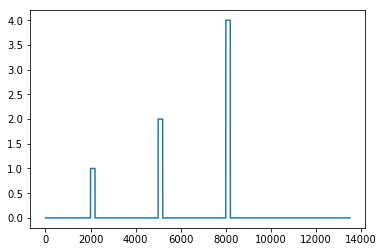

In [10]:
plt.plot(voltage)

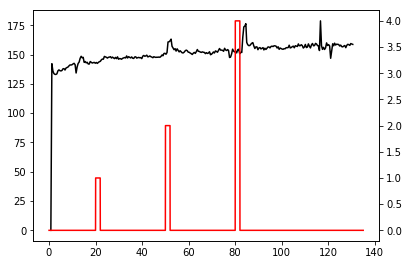

In [11]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.plot(timestamp, data.mean(axis=1), color = 'k')
ax11 = ax1.twinx()
range1 = np.array(range(len(voltage))) / 100
ax11.plot(range1, voltage, color = 'r')



In [12]:
#check relative time instead
import imp
imp.reload(cc2)

<module 'ccModules2' from '/groups/flyfuncconn/home/busheyd/scripts/Python/Modules/ccModules2.py'>

In [13]:
timeStampRelative = cc2.read_TimeSeries_HDF5(image_file).getTimeStampStart()
timeStampRelative = timeStampRelative[:]

In [14]:
print(timeStampRelative[-1])
print(timestamp[-1])

[ 129.75]
[ 130.5]


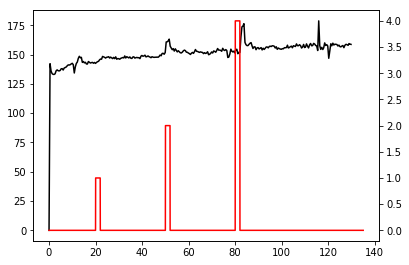

In [15]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.plot(timeStampRelative, data.mean(axis=1), color = 'k')
ax11 = ax1.twinx()
range1 = np.array(range(len(voltage))) / 100
ax11.plot(range1, voltage, color = 'r')

In [ ]:
#realized the time stamp delay in the function was being applied wrong
'''
delay needs to be added when the last stim ended, whereas now being calculated from where it began
'''

In [ ]:

def getVoltage(xml_file, target_element = 'amber LED', time = 135 ):
    '''
    xml_file = path to xml file
    target_element = led used in stimulation
    time = total time in s for experiment
    return matrix similar to scanimage with intervales every 1 centisecond and equaling voltage
    '''
    tree = ET.parse(xml_file)
    root = tree.getroot()
    #the xml file is divided into waveforms. Each waveform contains a different stimulus.
    findwaves= root.findall('Waveform')   
    #find the waveform with the target stimulus
    targetwaveform =[]    
    for wave in findwaves:
        name1 = wave.findall('Name')
        #print(name1)
        for n in name1:
            if n.text == target_element:
                targetwaveform.append(wave)
    #get the stimulation data for each stimulus period in the waveform
    wavef = targetwaveform[0].findall('WaveformComponent_PulseTrain')
    timevariables = ['FirstPulseDelay', 'PulsePotentialStart', 'PulseCount', 'PulseWidth', 'PulseSpacing']
    timedict = {}
    for v in timevariables:
        timedict[v] = []
    for wave in wavef:
        for v in timevariables:
            vx = wave.findall(v)
            timedict[v].append(vx[0].text)
            
    frame1 = pd.DataFrame(timedict) 
    #create an index start stop
    frame1['start'] = ''
    frame1['stop'] = ''
    for row in range(len(frame1)):
        sum1 = frame1['FirstPulseDelay'].iloc[:row+1].as_matrix().astype(np.int64).sum()
        frame1['start'].iloc[row] = sum1 -1
        duration = int(frame1['PulseCount'].iloc[row]) * (int(frame1['PulseWidth'].iloc[row]) +int(frame1['PulseSpacing'].iloc[row]))
        frame1['stop'].iloc[row] = duration + frame1['start'].iloc[row] -1
    #generate a matrix with the same time s *100 (cs) as scanimage outputs
    matrix = np.zeros(time*100)
    for row, dseries in frame1.iterrows():
        matrix[int(frame1['start'].loc[row]/10) : int(frame1['stop'].loc[row]/10)] = frame1['PulsePotentialStart'].loc[row]
    return matrix

In [21]:
xml_file = '/data/JData/A/A57_GtACR_Mi1/A57_Data/20180601_A57/20180601-A62-16-flyc-001/20180601-A62-16-flyc-001_Cycle00001_VoltageOutput_001.xml'
target_element = 'amber LED'
time = 135
tree = ET.parse(xml_file)
root = tree.getroot()
#the xml file is divided into waveforms. Each waveform contains a different stimulus.
findwaves= root.findall('Waveform')   
#find the waveform with the target stimulus
targetwaveform =[]    
for wave in findwaves:
    name1 = wave.findall('Name')
    #print(name1)
    for n in name1:
        if n.text == target_element:
            targetwaveform.append(wave)
#get the stimulation data for each stimulus period in the waveform
wavef = targetwaveform[0].findall('WaveformComponent_PulseTrain')
timevariables = ['FirstPulseDelay', 'PulsePotentialStart', 'PulseCount', 'PulseWidth', 'PulseSpacing']
timedict = {}
for v in timevariables:
    timedict[v] = []
for wave in wavef:
    for v in timevariables:
        vx = wave.findall(v)
        timedict[v].append(vx[0].text)

frame1 = pd.DataFrame(timedict) 
#create an index start stop
frame1['start'] = ''
frame1['stop'] = ''
for row in range(len(frame1)):
    sum1 = frame1['FirstPulseDelay'].iloc[:row+1].as_matrix().astype(np.int64).sum()
    frame1['start'].iloc[row] = sum1 -1
    duration = int(frame1['PulseCount'].iloc[row]) * (int(frame1['PulseWidth'].iloc[row]) +int(frame1['PulseSpacing'].iloc[row]))
    frame1['stop'].iloc[row] = duration + frame1['start'].iloc[row] 
#generate a matrix with the same time s *100 (cs) as scanimage outputs
matrix = np.zeros(time*100)
for row, dseries in frame1.iterrows():
    matrix[int(frame1['start'].loc[row]/10) : int(frame1['stop'].loc[row]/10)] = frame1['PulsePotentialStart'].loc[row]

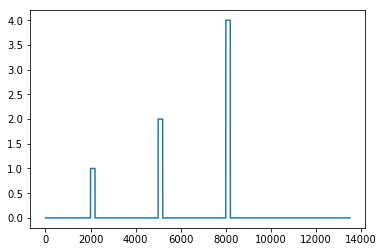

In [22]:
plt.plot(matrix)

In [23]:
frame1

,FirstPulseDelay,PulseCount,PulsePotentialStart,PulseSpacing,PulseWidth,start,stop
0,20000,100,1,18,2,19999,21998
1,30000,100,2,18,2,49999,51998
2,30000,100,4,18,2,79999,81998


In [65]:
xml_file = '/data/JData/A/A57_GtACR_Mi1/A57_Data/20180601_A57/20180601-A62-16-flyc-001/20180601-A62-16-flyc-001_Cycle00001_VoltageOutput_001.xml'
target_element = 'amber LED'
time = 135
tree = ET.parse(xml_file)
root = tree.getroot()
#the xml file is divided into waveforms. Each waveform contains a different stimulus.
findwaves= root.findall('Waveform')   
#find the waveform with the target stimulus
targetwaveform =[]    
for wave in findwaves:
    name1 = wave.findall('Name')
    #print(name1)
    for n in name1:
        if n.text == target_element:
            targetwaveform.append(wave)
#get the stimulation data for each stimulus period in the waveform
wavef = targetwaveform[0].findall('WaveformComponent_PulseTrain')
timevariables = ['FirstPulseDelay', 'PulsePotentialStart', 'PulseCount', 'PulseWidth', 'PulseSpacing']
timedict = {}
for v in timevariables:
    timedict[v] = []
for wave in wavef:
    for v in timevariables:
        vx = wave.findall(v)
        timedict[v].append(vx[0].text)

frame1 = pd.DataFrame(timedict) 
#create an index start stop
frame1['start'] = ''
frame1['stop'] = ''
#seed first row
fudge = 0#added because timing was off but could not find the reason
row =0
frame1['start'].iloc[row] = int(frame1['FirstPulseDelay'].iloc[row])-1
duration = int(frame1['PulseCount'].iloc[row]) * (int(frame1['PulseWidth'].iloc[row]) +int(frame1['PulseSpacing'].iloc[row]))
frame1['stop'].iloc[row] = duration + frame1['start'].iloc[row] +fudge

for row in range(1, len(frame1)):
    sum1 = int(frame1['stop'].iloc[row-1]) + int(frame1['FirstPulseDelay'].iloc[row])
    frame1['start'].iloc[row] = sum1-1
    duration = int(frame1['PulseCount'].iloc[row]) * ((int(frame1['PulseWidth'].iloc[row])-1) +(int(frame1['PulseSpacing'].iloc[row]))-1)
    frame1['stop'].iloc[row] = duration + frame1['start'].iloc[row] +fudge
#generate a matrix with the same time s *100 (cs) as scanimage outputs
matrix = np.zeros(time*100)
for row, dseries in frame1.iterrows():
    matrix[int(frame1['start'].loc[row]/10) : int(frame1['stop'].loc[row]/10)] = frame1['PulsePotentialStart'].loc[row]

frame1

,FirstPulseDelay,PulseCount,PulsePotentialStart,PulseSpacing,PulseWidth,start,stop
0,20000,100,1,18,2,19999,21999
1,30000,100,2,18,2,51998,53798
2,30000,100,4,18,2,83797,85597


(125, 175)

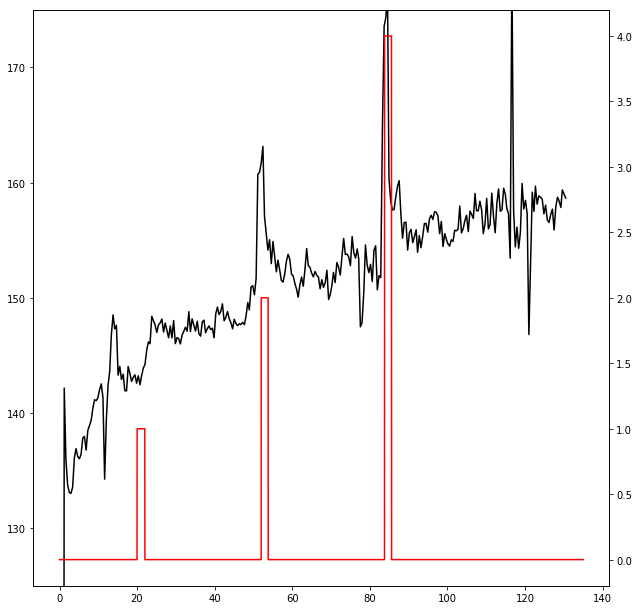

In [66]:
fig1 = plt.figure(figsize = [10,10])
ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.plot(timestamp, data.mean(axis=1), color = 'k')
ax11 = ax1.twinx()
range1 = np.array(range(len(matrix))) / 100
ax11.plot(range1, matrix, color = 'r')
ax1.set_ylim([125, 175])

In [67]:
def getVoltage(xml_file, target_element = 'amber LED', time = 135 ):
    '''
    xml_file = path to xml file
    target_element = led used in stimulation
    time = total time in s for experiment
    return matrix similar to scanimage with intervales every 1 centisecond and equaling voltage
    '''
    tree = ET.parse(xml_file)
    root = tree.getroot()
    #the xml file is divided into waveforms. Each waveform contains a different stimulus.
    findwaves= root.findall('Waveform')   
    #find the waveform with the target stimulus
    targetwaveform =[]    
    for wave in findwaves:
        name1 = wave.findall('Name')
        #print(name1)
        for n in name1:
            if n.text == target_element:
                targetwaveform.append(wave)
    #get the stimulation data for each stimulus period in the waveform
    wavef = targetwaveform[0].findall('WaveformComponent_PulseTrain')
    timevariables = ['FirstPulseDelay', 'PulsePotentialStart', 'PulseCount', 'PulseWidth', 'PulseSpacing']
    timedict = {}
    for v in timevariables:
        timedict[v] = []
    for wave in wavef:
        for v in timevariables:
            vx = wave.findall(v)
            timedict[v].append(vx[0].text)

    frame1 = pd.DataFrame(timedict) 
    #create an index start stop
    frame1['start'] = ''
    frame1['stop'] = ''
    #seed first row
    fudge = 0#added because timing was off but could not find the reason
    row =0
    frame1['start'].iloc[row] = int(frame1['FirstPulseDelay'].iloc[row])-1
    duration = int(frame1['PulseCount'].iloc[row]) * (int(frame1['PulseWidth'].iloc[row]) +int(frame1['PulseSpacing'].iloc[row]))
    frame1['stop'].iloc[row] = duration + frame1['start'].iloc[row] +fudge

    for row in range(1, len(frame1)):
        sum1 = int(frame1['stop'].iloc[row-1]) + int(frame1['FirstPulseDelay'].iloc[row])
        frame1['start'].iloc[row] = sum1-1
        duration = int(frame1['PulseCount'].iloc[row]) * ((int(frame1['PulseWidth'].iloc[row])-1) +(int(frame1['PulseSpacing'].iloc[row]))-1)
        frame1['stop'].iloc[row] = duration + frame1['start'].iloc[row] +fudge
    #generate a matrix with the same time s *100 (cs) as scanimage outputs
    matrix = np.zeros(time*100)
    for row, dseries in frame1.iterrows():
        matrix[int(frame1['start'].loc[row]/10) : int(frame1['stop'].loc[row]/10)] = frame1['PulsePotentialStart'].loc[row]
    return matrix

(125, 175)

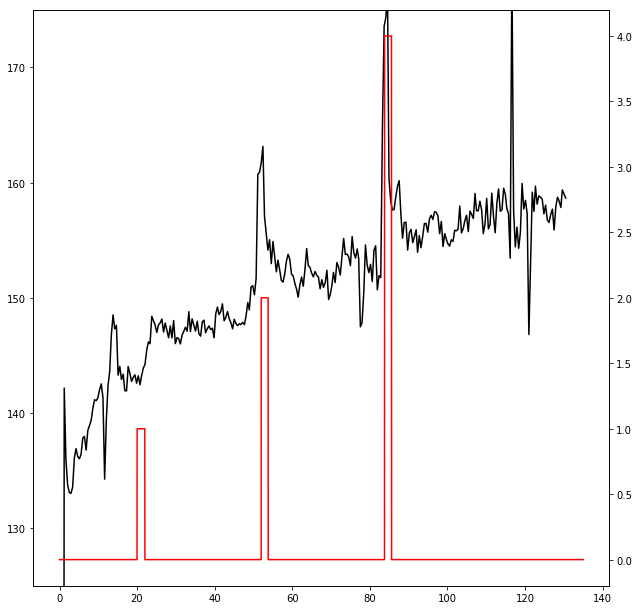

In [68]:
matrix = getVoltage(xml_file)
fig1 = plt.figure(figsize = [10,10])
ax1 = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.plot(timestamp, data.mean(axis=1), color = 'k')
ax11 = ax1.twinx()
range1 = np.array(range(len(matrix))) / 100
ax11.plot(range1, matrix, color = 'r')
ax1.set_ylim([125, 175])

In [30]:
frame1

,FirstPulseDelay,PulseCount,PulsePotentialStart,PulseSpacing,PulseWidth,start,stop
0,20000,100,1,18,2,0,2000
1,30000,100,2,18,2,,
2,30000,100,4,18,2,,
